# Import Relevant Libaries

## Install relevant versions

In [4]:
!pip install monai==1.4.0
!pip install pandas==2.0.3
!pip install nibabel

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 60.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 63.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.3
    Uninstalling pandas-2.2.3:
      Successfully uninstalled pandas-2.2.3


In [1]:
import os
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
from monai.networks.schedulers import DDPMScheduler
from monai.inferers.inferer import DiffusionInferer
from torch.optim.lr_scheduler import MultiStepLR
import pandas as pd
from monai.bundle import ConfigParser
import nibabel as nib
from torch.utils.data import Dataset

#%% Setup device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

<frozen importlib._bootstrap_external>:1184: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.


# Setup Paths

In [2]:
# Setup paths to uploaded training data
training_dataset = 'TrainingData_Key/slices_40_new_anon-20250703T131958Z-1-001'

In [3]:
# Setup paths to uploaded config files
config_path_ = 'Configs/configs'

In [4]:
pretrained_path = 'trained_vAE_epoch_148.pt'

# Dataset Function

## Function to create datasets

In [5]:
def create_datasets(df, data_dir):

    df['Linked_Files_Anon'] = df['Linked_Files_Anon'].apply(lambda x: os.path.join(data_dir, x))

    train_data = df[df['Set']=='Train']
    valid_data = df[df['Set']=='Validation']
    test_data = df[df['Set']=='Test']

    train_data = train_data.reset_index()
    valid_data = valid_data.reset_index()
    test_data = test_data.reset_index()

    train_dataset = FDG_Dataset(data=train_data)
    valid_dataset = FDG_Dataset(data=valid_data)
    test_dataset = FDG_Dataset(data=test_data)

    return train_dataset, valid_dataset, test_dataset

## Dataset function

In [6]:
class FDG_Dataset(Dataset):
    """
    A PyTorch Dataset to load NIfTI files from a provided list of file paths.
    """
    def __init__(self, data):
        """
        Args:
            file_paths (list of Path objects): List of paths to the NIfTI files.
        """

        self.csv = data

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        diag = self.csv.loc[idx, 'DX_encoded']
        file_name = self.csv.loc[idx, 'Linked_Files_Anon']

        nii_img  = nib.load(file_name)
        nii_data = nii_img.get_fdata()

        nii_data_scaled = (nii_data - nii_data.min())/(nii_data.max() - nii_data.min())
        image_tensor = torch.from_numpy(nii_data_scaled)

        return image_tensor, diag


# Load Pre-trained VAE

In [7]:
# Config filename
config_file="train_autoencoder.json"

# Weights Filename
weights_file="trained_vAE_epoch_76.pt"

# Setup config filepath
config_path = os.path.join(config_path_, config_file)

# Setup weights filepath
weights_path = os.path.join(pretrained_path, weights_file)

# Read config
config = ConfigParser()
config.read_config(config_path)

# Parse model
vAE_model = config.get_parsed_content("gnetwork")

# Load checkpoint
checkpoint = torch.load(weights_path, map_location=device)

# Key remapping
key_mapping = {
    "encoder.blocks.10.to_q.weight": "encoder.blocks.10.attn.to_q.weight",
    "encoder.blocks.10.to_q.bias": "encoder.blocks.10.attn.to_q.bias",
    "encoder.blocks.10.to_k.weight": "encoder.blocks.10.attn.to_k.weight",
    "encoder.blocks.10.to_k.bias": "encoder.blocks.10.attn.to_k.bias",
    "encoder.blocks.10.to_v.weight": "encoder.blocks.10.attn.to_v.weight",
    "encoder.blocks.10.to_v.bias": "encoder.blocks.10.attn.to_v.bias",
    "encoder.blocks.10.proj_attn.weight": "encoder.blocks.10.attn.out_proj.weight",
    "encoder.blocks.10.proj_attn.bias": "encoder.blocks.10.attn.out_proj.bias",
    "decoder.blocks.2.to_q.weight": "decoder.blocks.2.attn.to_q.weight",
    "decoder.blocks.2.to_q.bias": "decoder.blocks.2.attn.to_q.bias",
    "decoder.blocks.2.to_k.weight": "decoder.blocks.2.attn.to_k.weight",
    "decoder.blocks.2.to_k.bias": "decoder.blocks.2.attn.to_k.bias",
    "decoder.blocks.2.to_v.weight": "decoder.blocks.2.attn.to_v.weight",
    "decoder.blocks.2.to_v.bias": "decoder.blocks.2.attn.to_v.bias",
    "decoder.blocks.2.proj_attn.weight": "decoder.blocks.2.attn.out_proj.weight",
    "decoder.blocks.2.proj_attn.bias": "decoder.blocks.2.attn.out_proj.bias",
    "decoder.blocks.6.conv.conv.weight": "decoder.blocks.6.postconv.conv.weight",
    "decoder.blocks.6.conv.conv.bias": "decoder.blocks.6.postconv.conv.bias",
    "decoder.blocks.9.conv.conv.weight": "decoder.blocks.9.postconv.conv.weight",
    "decoder.blocks.9.conv.conv.bias": "decoder.blocks.9.postconv.conv.bias",
}

# Remap keys
new_state_dict = {key_mapping.get(k, k): v for k, v in checkpoint.items()}

# Load state
vAE_model.load_state_dict(new_state_dict, strict=False)
vAE_model.to(device)


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


#Create LDM

In [ ]:
# Load config file
config_file="train_diffusion.json"

# Setup config filepath
config_path = os.path.join(config_path_, config_file)

# Read config
config = ConfigParser()
config.read_config(config_path)

# Parse model
LDM_model = config.get_parsed_content("diffusion")

#Setup parameters of LDM

In [ ]:
import math

class CombinedScheduler(torch.optim.lr_scheduler._LRScheduler):

    def __init__(self, optimizer, warmup_epochs, training_epochs, cooldown_epochs, init_lr, fin_lr, last_epoch=-1):

        self.warmup_epochs = warmup_epochs

        self.training_epochs = training_epochs

        self.cooldown_epochs = cooldown_epochs

        self.init_lr = init_lr

        self.fin_lr = fin_lr

        super().__init__(optimizer, last_epoch=last_epoch)

    def get_lr(self):

        epoch = self.last_epoch

        # Warmup phase: linearly increase from 1e-8 to init_lr

        if epoch < self.warmup_epochs:

            progress = epoch / self.warmup_epochs

            return [1e-8 + (self.init_lr - 1e-8) * progress for _ in self.base_lrs]

        # Training phase: cosine decay from init_lr to fin_lr

        elif epoch < self.warmup_epochs + self.training_epochs:

            progress = (epoch - self.warmup_epochs) / self.training_epochs

            cosine_decay = 0.5 * (1 + math.cos(progress * math.pi))

            return [self.fin_lr + (self.init_lr - self.fin_lr) * cosine_decay for _ in self.base_lrs]

        # Cooldown phase: linearly decrease from fin_lr to 1e-8

        elif epoch < self.warmup_epochs + self.training_epochs + self.cooldown_epochs:

            progress = (epoch - self.warmup_epochs - self.training_epochs) / self.cooldown_epochs

            return [self.fin_lr + (1e-8 - self.fin_lr) * progress for _ in self.base_lrs]

        # Beyond all phases: hold at the minimum lr (1e-8)

        else:

            return [1e-8 for _ in self.base_lrs]


In [ ]:
# Datasets / Dataloader
data = os.path.join('TrainingData_Key/data_key_anon.csv')
data = pd.read_csv(data)
train_dataset, valid_dataset, test_dataset = create_datasets(data, training_dataset)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, persistent_workers=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, persistent_workers=True)

# Epochs
training_epochs = 500

# Learning rate
init_lr = 5e-05
fin_lr = 1e-08
# Optimizer
optimiser = optim.Adam(LDM_model.parameters(), lr=init_lr)
# Learning rate scheduler
#lr_scheduler = CombinedScheduler(optimiser, 1, training_epochs, 20, init_lr, fin_lr)

# LDM Scheduler
ldm_scheduler = DDPMScheduler(schedule="scaled_linear_beta", num_train_timesteps=1000, beta_start=0.0015, beta_end= 0.0195)

# Inferer
inferer = DiffusionInferer(ldm_scheduler)

# Output folder
output_folder = '/content/output'

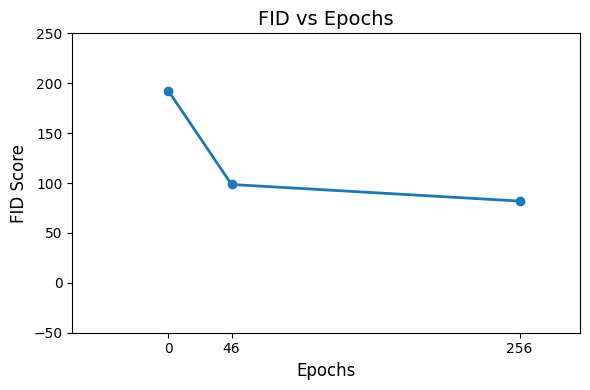

In [30]:
import matplotlib.pyplot as plt

# Data
epochs = [0, 46, 256]
fid_scores = [192.35, 98.57, 81.94]

# Plot
plt.figure(figsize=(6, 4))
plt.plot(epochs, fid_scores, marker='o', linestyle='-', linewidth=2)
plt.title("FID vs Epochs", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("FID Score", fontsize=12)
plt.xticks(epochs, fontsize=10)
plt.yticks(fontsize=10)
plt.xlim(-70, 300)
plt.ylim(-50, max(fid_scores) * 1.3)


plt.tight_layout()
plt.show()

# Code to train unconditional LDM

In [8]:
import time
# Latent space: Batch size, latent channels, X, Y

# Loss

# Padding used for the latent space

# Epoch loop

# Dataloader loop

# Encode data via latent space

# Create noise like the mean

# Timesteps

# Set optimizer to zero

# Initial prediction via inferer

# Calculate loss

# Send loss backwards

# Optimizer step

# Validation data_loader

# Code for validation loss

import time
import torch
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import matplotlib.pyplot as plt

val_interval = 1
epoch_loss_list = []
val_epoch_loss_list = []

scaler = GradScaler()
total_start = time.time()

vAE_model.eval()
LDM_model.to(device)
vAE_model.to(device)

best_val = 1e3

for epoch in range(training_epochs):



    LDM_model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images, _ = batch
        optimiser.zero_grad(set_to_none=True)

        with torch.no_grad():
          z_mean, z_std = vAE_model.encode(images.float().unsqueeze(dim=1).to(device))

        padded_z_mean = F.pad(z_mean, (2, 2, 2, 2))  # pad 4 pixels on right and bottom

        padded_z_mean = padded_z_mean.to(device)

        with autocast(enabled=True):
            # Generate random noise
            noise = torch.randn_like(padded_z_mean).to(device)
            # Create timesteps
            timesteps = torch.randint(
                0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
            ).long().to(device)

            # Get model prediction
            noise_pred = inferer(inputs=padded_z_mean, diffusion_model=LDM_model, noise=noise, timesteps=timesteps)

            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimiser)
        scaler.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": loss})
    epoch_loss_list.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        LDM_model.eval()
        val_epoch_loss = 0
        for step, batch in enumerate(valid_loader):
          images, _ = batch
          optimiser.zero_grad(set_to_none=True)

          with torch.no_grad():
            z_mean, z_std = vAE_model.encode(images.float().unsqueeze(dim=1).to(device))

            padded_z_mean = F.pad(z_mean, (2, 2, 2, 2))  # pad 4 pixels on right and bottom

            padded_z_mean = padded_z_mean.to(device)

            with autocast(enabled=True):
                # Generate random noise
                noise = torch.randn_like(padded_z_mean).to(device)
                # Create timesteps
                timesteps = torch.randint(
                    0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                ).long().to(device)

                # Get model prediction
                noise_pred = inferer(inputs=padded_z_mean, diffusion_model=LDM_model, noise=noise, timesteps=timesteps)

                val_loss = F.mse_loss(noise_pred.float(), noise.float())

            val_epoch_loss += val_loss.item()
            progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})

        val_epoch_loss_list.append(val_epoch_loss / (step + 1))

        print(f"Epoch {epoch}, Training Loss: {epoch_loss / (step + 1)}, Validation Loss: {val_epoch_loss / (step + 1)}")

        if val_epoch_loss / (step + 1) < best_val:
          best_val = val_epoch_loss / (step + 1)
          torch.save(LDM_model.state_dict(), os.path.join('Checkpoints', f"trained_LDM_epoch_{epoch}.pt"))

          # Sampling image during training
          noise = torch.randn((1, 1, 64, 64))
          noise = noise.to(device)
          ldm_scheduler.set_timesteps(num_inference_steps=1000)
          with autocast(enabled=True):
              image = inferer.sample(input_noise=noise, diffusion_model=LDM_model, scheduler=ldm_scheduler)
              image = image[:, :, 2:-2, 2:-2]
              image = vAE_model.decode(image).cpu().detach().numpy()

          plt.figure(figsize=(2, 2))
          plt.imshow(image[0, 0], vmin=0, vmax=1, cmap="gray")
          plt.tight_layout()
          plt.axis("off")
          plt.show()

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

/tmp/ipykernel_1521591/773758884.py:43: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


NameError: name 'LDM_model' is not defined

/tmp/ipykernel_1514281/2241218373.py:3: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


tensor(4.4527e-05)


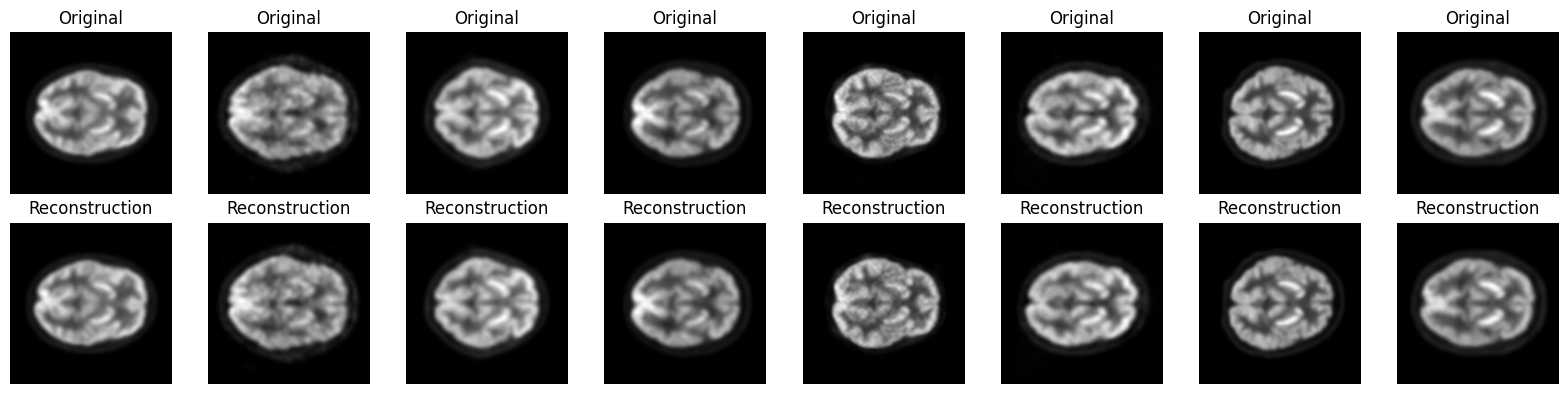

In [30]:
# Visualize reconstructions
vAE_model.eval()
with autocast(enabled=True):
    with torch.no_grad():
      images, _ = next(iter(test_loader))  # Grab a small batch
      images = images[:8]  # limit to 8 for easy plotting
      images = images.float().unsqueeze(1).to(device)
    
      z_mean, _ = vAE_model.encode(images)
      recon = vAE_model.decode(z_mean).cpu()  # shape: [B, 1, H, W]
    
      originals = images.cpu()
      print(np.min(originals[0]))
      print(np.max(originals[0]))
      print(np.min(recon[0]))
      print(np.max(recon[0]))

      print(F.mse_loss(originals, recon))
    
      # Plot
      n = images.size(0)
      fig, axes = plt.subplots(2, n, figsize=(n * 2, 4))
      for i in range(n):
          axes[0, i].imshow(originals[i, 0], cmap='gray', vmin=0, vmax=1)
          axes[0, i].axis('off')
          axes[0, i].set_title('Original')
    
          axes[1, i].imshow(recon[i, 0], cmap='gray', vmin=0, vmax=1)
          axes[1, i].axis('off')
          axes[1, i].set_title('Reconstruction')
    
      plt.tight_layout()
      plt.show()


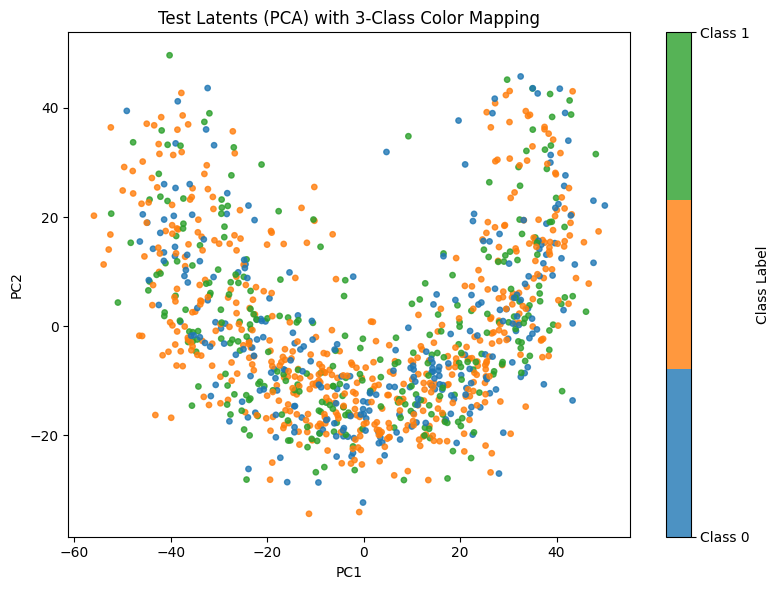

In [40]:
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 1: Extract & flatten latents from train_loader for PCA fitting
vAE_model.eval()
train_latents = []

with torch.no_grad():
    for batch in train_loader:
        images, _ = batch
        images = images.float().unsqueeze(1).to(device)

        z_mean, _ = vAE_model.encode(images)
        B, C, H, W = z_mean.shape
        z_flat = z_mean.view(B, -1)  # flatten to [B, D]

        train_latents.append(z_flat.cpu())

train_latents = torch.cat(train_latents, dim=0).numpy()

# Step 2: Fit PCA on train latents
pca = PCA(n_components=2)
pca.fit(train_latents)

# Step 3: Extract latents from test_loader and transform via trained PCA
test_latents = []
train_labels = []

with torch.no_grad():
    for batch in train_loader:
        images, labels = batch
        images = images.float().unsqueeze(1).to(device)

        z_mean, _ = vAE_model.encode(images)
        z_flat = z_mean.view(z_mean.size(0), -1).cpu()

        test_latents.append(z_flat)
        train_labels.append(labels)

test_latents = torch.cat(test_latents, dim=0).numpy()
train_labels = torch.cat(train_labels, dim=0).numpy()

# Step 4: Transform test latents using PCA fitted on train latents
test_pca_result = pca.transform(train_latents)  # shape [N_test, 2]

# Define 3 clear colors (adjust as needed)
custom_cmap = ListedColormap(['#1f77b4', '#ff7f0e', '#2ca02c'])  # blue, orange, green

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    test_pca_result[:, 0],
    test_pca_result[:, 1],
    c=train_labels,
    cmap=custom_cmap,
    s=15,
    alpha=0.8
)

# Custom colorbar
cbar = plt.colorbar(scatter, ticks=[0, 1, 2])
cbar.set_label("Class Label")
cbar.set_ticklabels(['Class 0', 'Class 1', 'Class 2'])

plt.title("Test Latents (PCA) with 3-Class Color Mapping")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()


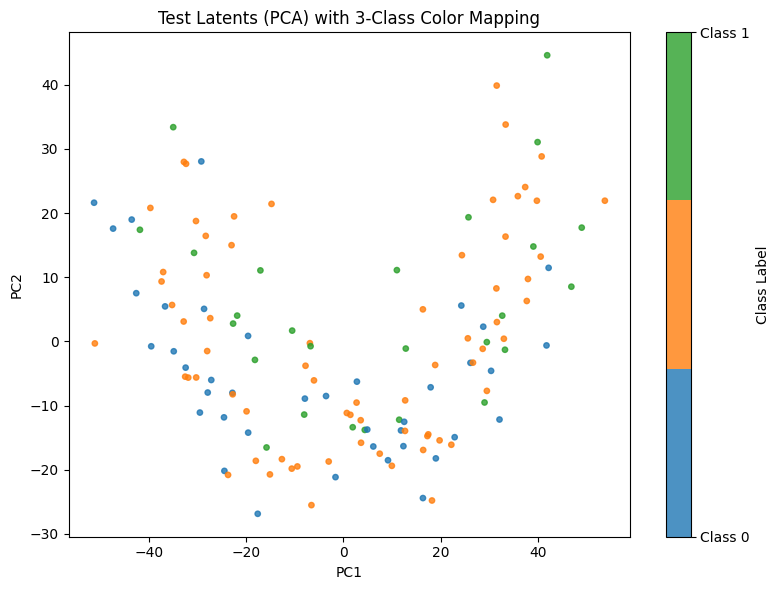

In [34]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

# Define 3 clear colors (adjust as needed)
custom_cmap = ListedColormap(['#1f77b4', '#ff7f0e', '#2ca02c'])  # blue, orange, green

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    test_pca_result[:, 0],
    test_pca_result[:, 1],
    c=test_labels,
    cmap=custom_cmap,
    s=15,
    alpha=0.8
)

# Custom colorbar
cbar = plt.colorbar(scatter, ticks=[0, 1, 2])
cbar.set_label("Class Label")
cbar.set_ticklabels(['Class 0', 'Class 1', 'Class 2'])

plt.title("Test Latents (PCA) with 3-Class Color Mapping")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()